In [3]:
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
#import optuna
import keras_tuner as kt

In [4]:
tf.random.set_seed(42)

In [5]:
def vectorise_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
x_train = vectorise_sequences(train_data)
x_test = vectorise_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
def plot_metrics(history, title):
   print("Available metrics:", history.history.keys())
   epochs = range(1, len(history.epoch) + 1)
   plt.figure(figsize=(20, 5))

   plt.subplot(1, 4, 1)
   plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
   plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
   plt.title(f'{title} - Accuracy')
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   plt.legend()

   plt.subplot(1, 4, 2)
   plt.plot(epochs, history.history['precision'], label='Training Precision')
   plt.plot(epochs, history.history['val_precision'], label='Validation Precision')
   plt.title(f'{title} - Precision')
   plt.xlabel('Epochs')
   plt.ylabel('Precision')
   plt.legend()

   plt.subplot(1, 4, 3)
   plt.plot(epochs, history.history['recall'], label='Training Recall')
   plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
   plt.title(f'{title} - Recall')
   plt.xlabel('Epochs')
   plt.ylabel('Recall')
   plt.legend()

   plt.subplot(1, 4, 4)
   plt.plot(epochs, history.history['f1_score'], label='Training F1')
   plt.plot(epochs, history.history['val_f1_score'], label='Validation F1')
   plt.title(f'{title} - F1 Score')
   plt.xlabel('Epochs')
   plt.ylabel('F1 Score')
   plt.legend()

   plt.tight_layout()
   plt.show()

In [7]:
def print_metrics(name, metrics):
   print(f"\n{name} Model Metrics:")
   print(f"Loss: {metrics[0]:.4f}")
   print(f"Accuracy: {metrics[1]:.4f}")
   print(f"Precision: {metrics[2]:.4f}")
   print(f"Recall: {metrics[3]:.4f}")
   print(f"F1 Score: {metrics[4]:.4f}")

In [8]:
metrics = [
    'accuracy',        # matches Accuracy: {metrics[1]}
    'precision',    # Changed from tf.keras.metrics.Precision() to 'precision'
    'recall',       # Changed from tf.keras.metrics.Recall() to 'recall'
    tf.keras.metrics.F1Score(average='weighted', threshold=None, name='f1_score')  # Added name='f1_score' for consistency
]

In [9]:
def analyse_overfitting(history, model_name):
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    val_f1 = history.history['val_f1_score']
    train_f1 = history.history['f1_score']
    val_acc = history.history['val_accuracy']
    train_acc = history.history['accuracy']

    optimal_epoch_f1 = np.argmax(val_f1) + 1
    optimal_epoch_acc = np.argmax(val_acc) + 1

    print(f"\nOverfitting Analysis for {model_name}:")
    print("-" * 50)
    print(f"Optimal epoch (F1): {optimal_epoch_f1}")
    print(f"Optimal epoch (Accuracy): {optimal_epoch_acc}")
    print(f"Best validation F1: {max(val_f1):.4f}")
    print(f"Best validation Accuracy: {max(val_acc):.4f}")
    print(f"Final F1 gap (train-val): {train_f1[-1] - val_f1[-1]:.4f}")
    print(f"Final Accuracy gap (train-val): {train_acc[-1] - val_acc[-1]:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.1622 - f1_score: 0.1731 - loss: 3.7485 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4540 - val_f1_score: 0.3308 - val_loss: 3.4785 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4560 - f1_score: 0.3270 - loss: 3.3982 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4830 - val_f1_score: 0.3514 - val_loss: 3.1631 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4856 - f1_score: 0.3503 - loss: 3.1004 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5020 - val_f1_score: 0.3671 - val_loss: 2.9086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5015 - f1_score: 0.3637 - loss: 2.8632 - precision: 0.2353 - recall: 3.0605e-05 - val_accuracy: 0.5110 - val_f1_score: 0.3747 - val_lo

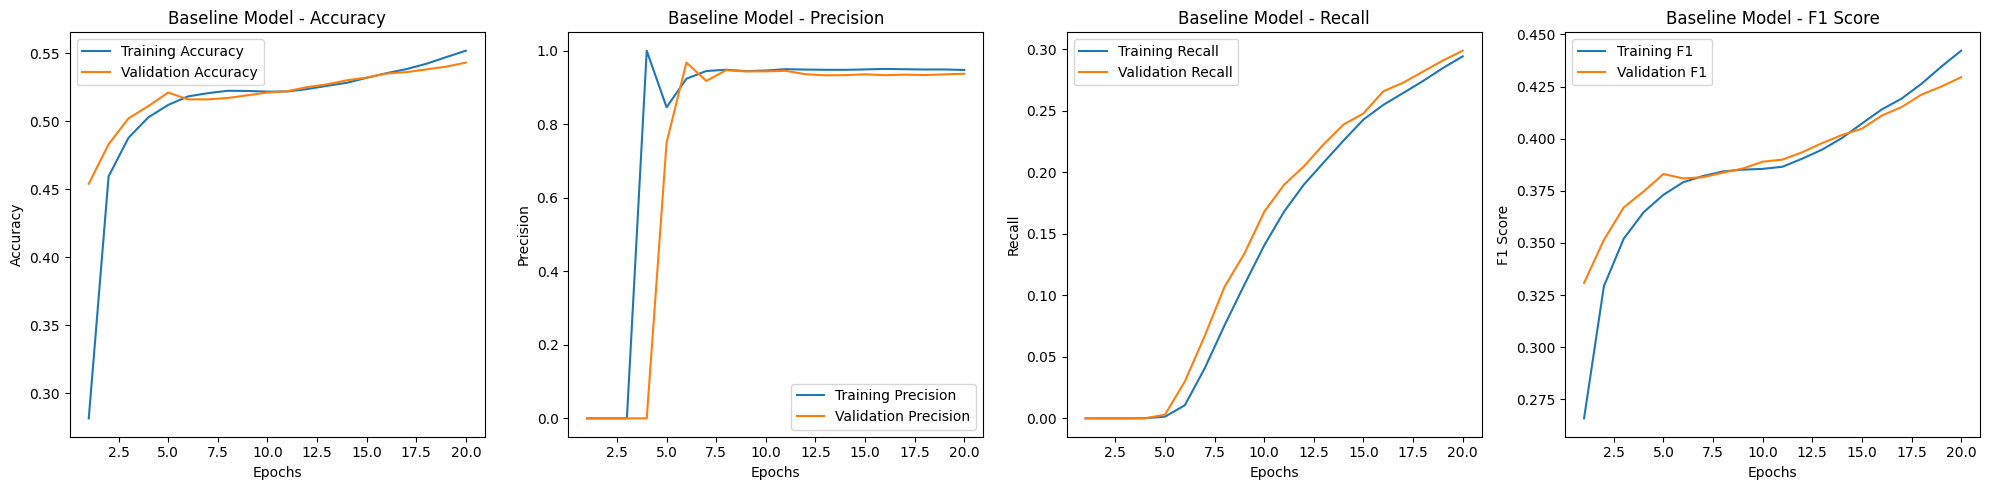

In [10]:
# Create validation set
val_data = x_train[:1000]
val_labels = one_hot_train_labels[:1000]
partial_train_data = x_train[1000:]
partial_train_labels = one_hot_train_labels[1000:]

# Build the model
model = Sequential([
    Dense(46, activation='softmax', input_shape=(10000,))
])

# Define metrics
metrics = [
    'accuracy',
    'precision',
    'recall',
    tf.keras.metrics.F1Score(average='weighted', threshold=None, name='f1_score')
]

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=metrics
)

# Train the model
history = model.fit(
    partial_train_data,
    partial_train_labels,
    epochs=20,
    batch_size=512,
    validation_data=(val_data, val_labels)
)

# Evaluate the model
test_metrics = model.evaluate(x_test, one_hot_test_labels, verbose=0)

# Print metrics
print_metrics("Baseline", test_metrics)

# Plot training history
plot_metrics(history, "Baseline Model")


2. Training Small Model
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.4883 - f1_score: 0.4555 - loss: 2.7150 - precision: 0.7074 - recall: 0.1321 - val_accuracy: 0.7379 - val_f1_score: 0.6835 - val_loss: 1.2291 - val_precision: 0.8971 - val_recall: 0.5871
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7947 - f1_score: 0.7565 - loss: 0.9530 - precision: 0.9212 - recall: 0.6632 - val_accuracy: 0.7863 - val_f1_score: 0.7557 - val_loss: 0.9705 - val_precision: 0.8935 - val_recall: 0.6678
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8888 - f1_score: 0.8776 - loss: 0.5630 - precision: 0.9459 - recall: 0.7852 - val_accuracy: 0.8102 - val_f1_score: 0.7932 - val_loss: 0.8718 - val_precision: 0.8827 - val_recall: 0.7078
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9267 - f1_score: 0.9238 - loss: 0.3618 - precision: 0.9553 - recall: 0.8699 - val_accuracy: 0.8108 - val_f1_score: 0.7948 - val_loss: 0.8404 - val_precision:

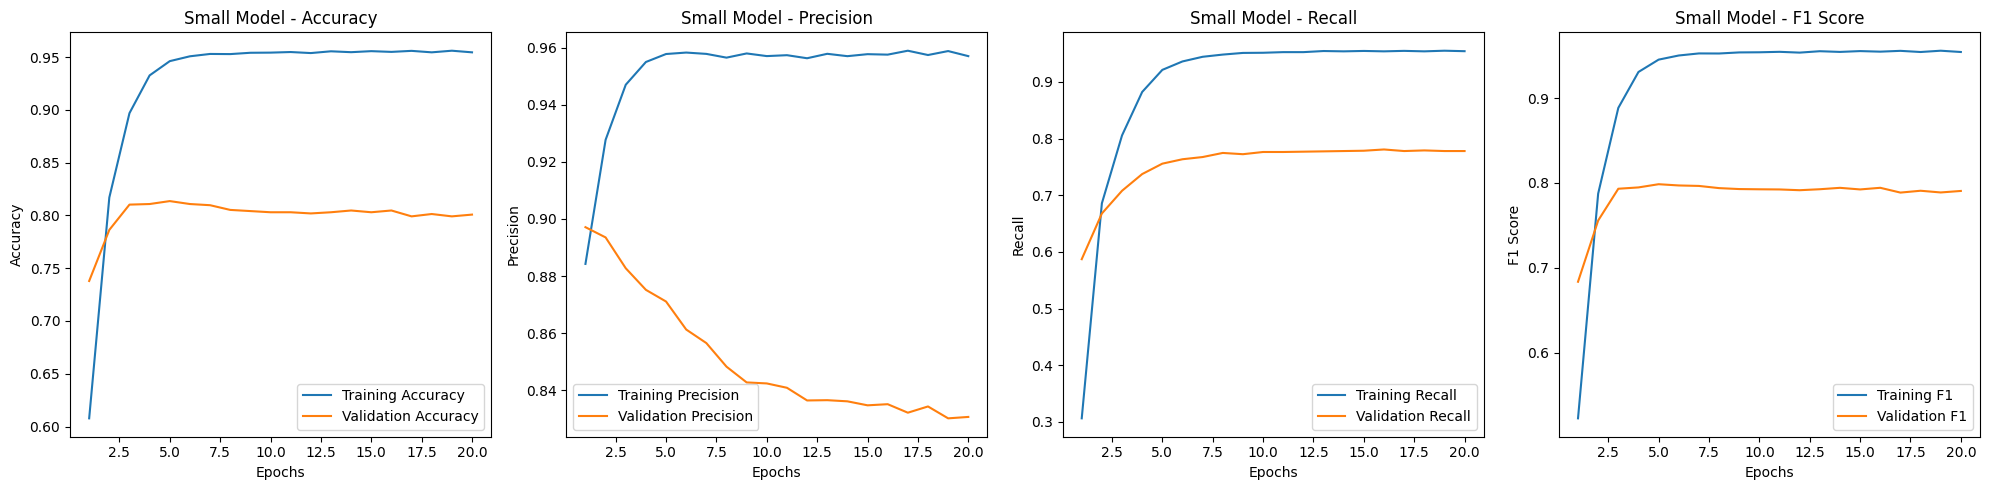


Overfitting Analysis for Small Model:
--------------------------------------------------
Optimal epoch (F1): 5
Optimal epoch (Accuracy): 5
Best validation F1: 0.7985
Best validation Accuracy: 0.8136
Final F1 gap (train-val): 0.1639
Final Accuracy gap (train-val): 0.1537


In [11]:
# Small model
print("\n2. Training Small Model")
small_model = Sequential([
    Dense(128, activation='relu', input_shape=(10000,)),
    Dense(46, activation='softmax')
])
small_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=metrics)

small_history = small_model.fit(
    x_train, one_hot_train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)
plot_metrics(small_history, "Small Model")
analyse_overfitting(small_history, "Small Model")


3. Training Bigger Model
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4834 - f1_score: 0.5986 - loss: 2.7469 - precision: 0.7298 - recall: 0.1466 - val_accuracy: 0.7123 - val_f1_score: 0.6480 - val_loss: 1.2693 - val_precision: 0.9037 - val_recall: 0.5954
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7754 - f1_score: 0.7289 - loss: 1.0254 - precision: 0.9226 - recall: 0.6498 - val_accuracy: 0.7780 - val_f1_score: 0.7467 - val_loss: 1.0087 - val_precision: 0.8880 - val_recall: 0.6750
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8768 - f1_score: 0.8609 - loss: 0.5765 - precision: 0.9471 - recall: 0.7827 - val_accuracy: 0.8024 - val_f1_score: 0.7837 - val_loss: 0.9122 - val_precision: 0.8749 - val_recall: 0.7123
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9288 - f1_score: 0.9252 - loss: 0.3409 - precision: 0.9547 - recall: 0.8698 - val_accuracy: 0.8086 - val_f1_score: 0.7971 - val_loss: 0.8961 - val_precision

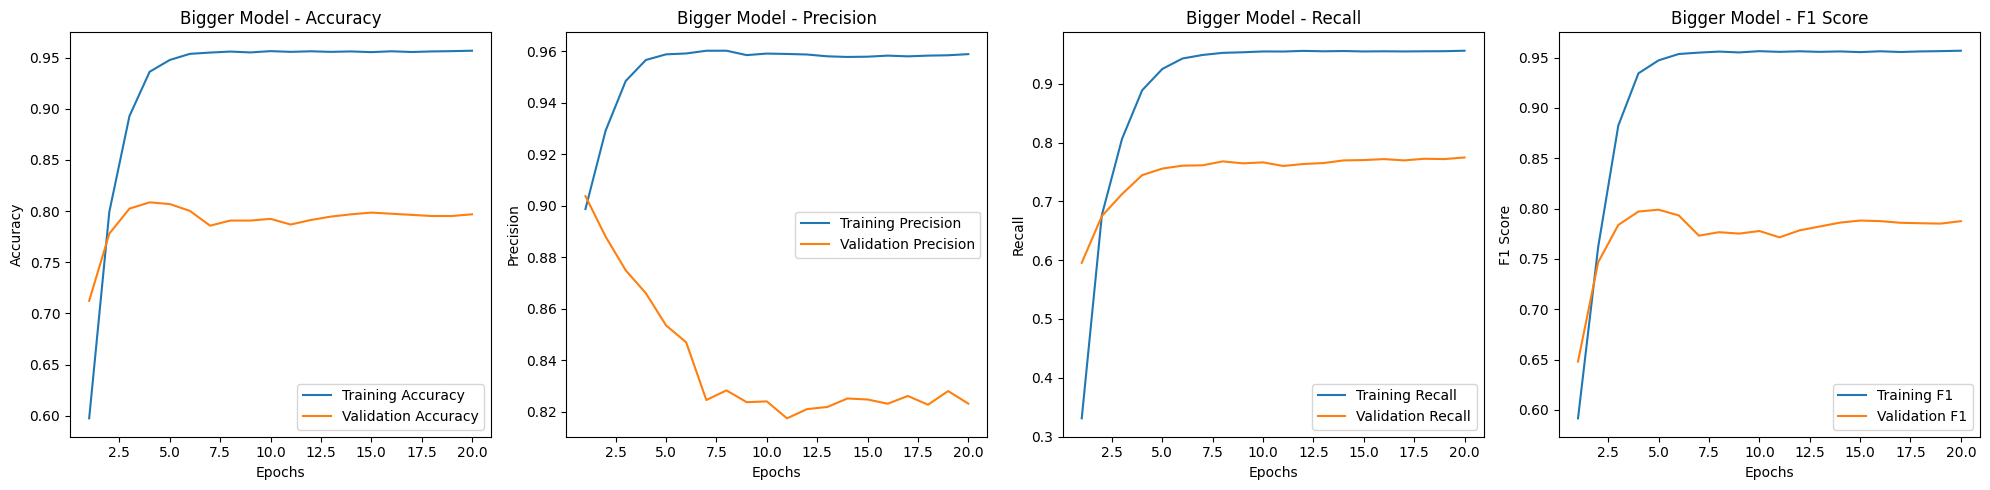


Overfitting Analysis for Bigger Model:
--------------------------------------------------
Optimal epoch (F1): 5
Optimal epoch (Accuracy): 4
Best validation F1: 0.7989
Best validation Accuracy: 0.8086
Final F1 gap (train-val): 0.1693
Final Accuracy gap (train-val): 0.1600


In [12]:
# Bigger model
print("\n3. Training Bigger Model")
bigger_model = Sequential([
    Dense(128, activation='relu', input_shape=(10000,)),
    Dense(64, activation='relu'),
    Dense(46, activation='softmax')
])
bigger_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=metrics)

bigger_history = bigger_model.fit(
    x_train, one_hot_train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)
plot_metrics(bigger_history, "Bigger Model")
analyse_overfitting(bigger_history, "Bigger Model")


3. Training Bigger Model 2 
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5043 - f1_score: 0.6135 - loss: 2.4739 - precision: 0.7426 - recall: 0.2322 - val_accuracy: 0.7412 - val_f1_score: 0.6918 - val_loss: 1.1216 - val_precision: 0.8912 - val_recall: 0.6427
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8165 - f1_score: 0.7811 - loss: 0.8316 - precision: 0.9239 - recall: 0.7160 - val_accuracy: 0.7841 - val_f1_score: 0.7581 - val_loss: 0.9275 - val_precision: 0.8780 - val_recall: 0.7012
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9128 - f1_score: 0.9052 - loss: 0.4092 - precision: 0.9486 - recall: 0.8489 - val_accuracy: 0.8036 - val_f1_score: 0.7886 - val_loss: 0.8924 - val_precision: 0.8662 - val_recall: 0.7490
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9423 - f1_score: 0.9409 - loss: 0.2582 - precision: 0.9531 - recall: 0.9161 - val_accuracy: 0.8097 - val_f1_score: 0.7996 - val_loss: 0.9399 - val_precis

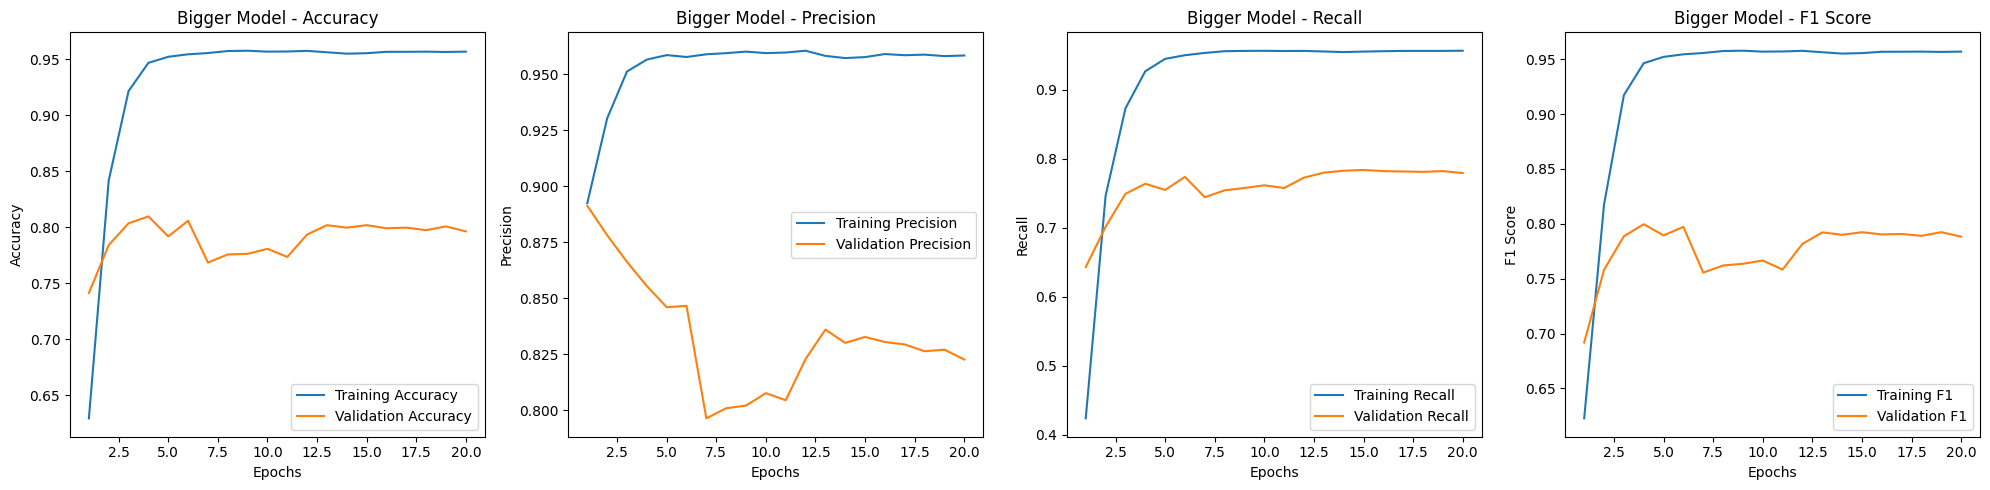


Overfitting Analysis for Bigger Model:
--------------------------------------------------
Optimal epoch (F1): 4
Optimal epoch (Accuracy): 4
Best validation F1: 0.7996
Best validation Accuracy: 0.8097
Final F1 gap (train-val): 0.1686
Final Accuracy gap (train-val): 0.1605


In [13]:
# Bigger model 2
print("\n3. Training Bigger Model 2 ")
bigger_model2 = Sequential([
    Dense(256, activation='relu', input_shape=(10000,)),
    Dense(128, activation='relu'),
    Dense(46, activation='softmax')
])
bigger_model2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=metrics)

bigger_history2 = bigger_model2.fit(
    x_train, one_hot_train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)
plot_metrics(bigger_history2, "Bigger Model")
analyse_overfitting(bigger_history2, "Bigger Model")


4. Training Regularised Model
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4143 - f1_score: 0.5487 - loss: 2.9963 - precision: 0.6548 - recall: 0.1397 - val_accuracy: 0.7190 - val_f1_score: 0.6596 - val_loss: 1.4695 - val_precision: 0.9054 - val_recall: 0.5860
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7681 - f1_score: 0.7223 - loss: 1.2581 - precision: 0.9165 - recall: 0.6380 - val_accuracy: 0.7674 - val_f1_score: 0.7292 - val_loss: 1.2629 - val_precision: 0.8891 - val_recall: 0.6694
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8558 - f1_score: 0.8330 - loss: 0.9086 - precision: 0.9382 - recall: 0.7588 - val_accuracy: 0.7824 - val_f1_score: 0.7556 - val_loss: 1.2088 - val_precision: 0.8748 - val_recall: 0.6923
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8976 - f1_score: 0.8876 - loss: 0.7391 - precision: 0.9470 - recall: 0.8203 - val_accuracy: 0.7885 - val_f1_score: 0.7675 - val_loss: 1.1945 - val_prec

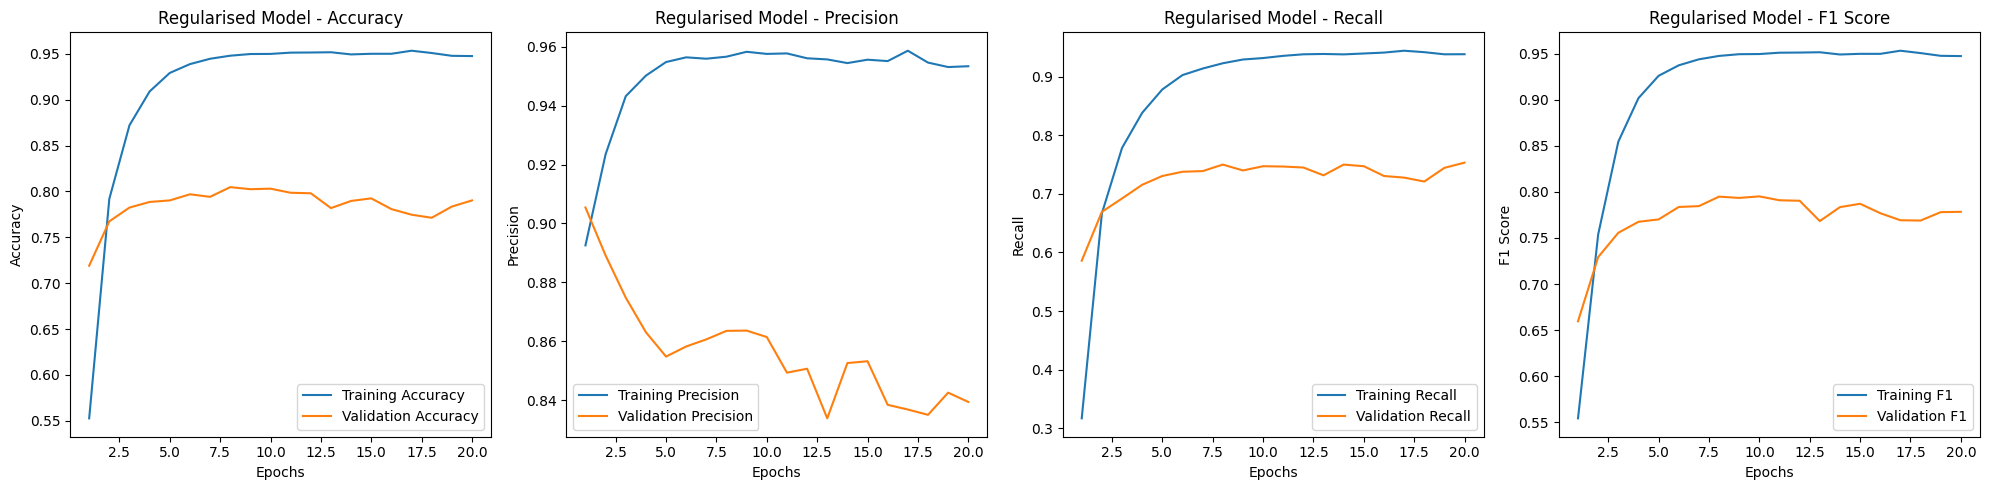


Overfitting Analysis for Regularised Model:
--------------------------------------------------
Optimal epoch (F1): 10
Optimal epoch (Accuracy): 8
Best validation F1: 0.7951
Best validation Accuracy: 0.8047
Final F1 gap (train-val): 0.1690
Final Accuracy gap (train-val): 0.1573


In [14]:
# Regularised model
print("\n4. Training Regularised Model")
regularised_model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(10000,)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(46, activation='softmax')
])
regularised_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)
regularised_history = regularised_model.fit(
    x_train, one_hot_train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)
plot_metrics(regularised_history, "Regularised Model")
analyse_overfitting(regularised_history, "Regularised Model")


4. Training Regularised Model 2
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3371 - f1_score: 0.5186 - loss: 3.3004 - precision: 0.5909 - recall: 0.0886 - val_accuracy: 0.6533 - val_f1_score: 0.5731 - val_loss: 1.7277 - val_precision: 0.9086 - val_recall: 0.5147
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6275 - f1_score: 0.5530 - loss: 1.7699 - precision: 0.9000 - recall: 0.4950 - val_accuracy: 0.7112 - val_f1_score: 0.6433 - val_loss: 1.4518 - val_precision: 0.9108 - val_recall: 0.6021
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6897 - f1_score: 0.6227 - loss: 1.5313 - precision: 0.9121 - recall: 0.5817 - val_accuracy: 0.7312 - val_f1_score: 0.6756 - val_loss: 1.3762 - val_precision: 0.9073 - val_recall: 0.6483
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7227 - f1_score: 0.6660 - loss: 1.3691 - precision: 0.9164 - recall: 0.6271 - val_accuracy: 0.7518 - val_f1_score: 0.7037 - val_loss: 1.3278 - val_pr

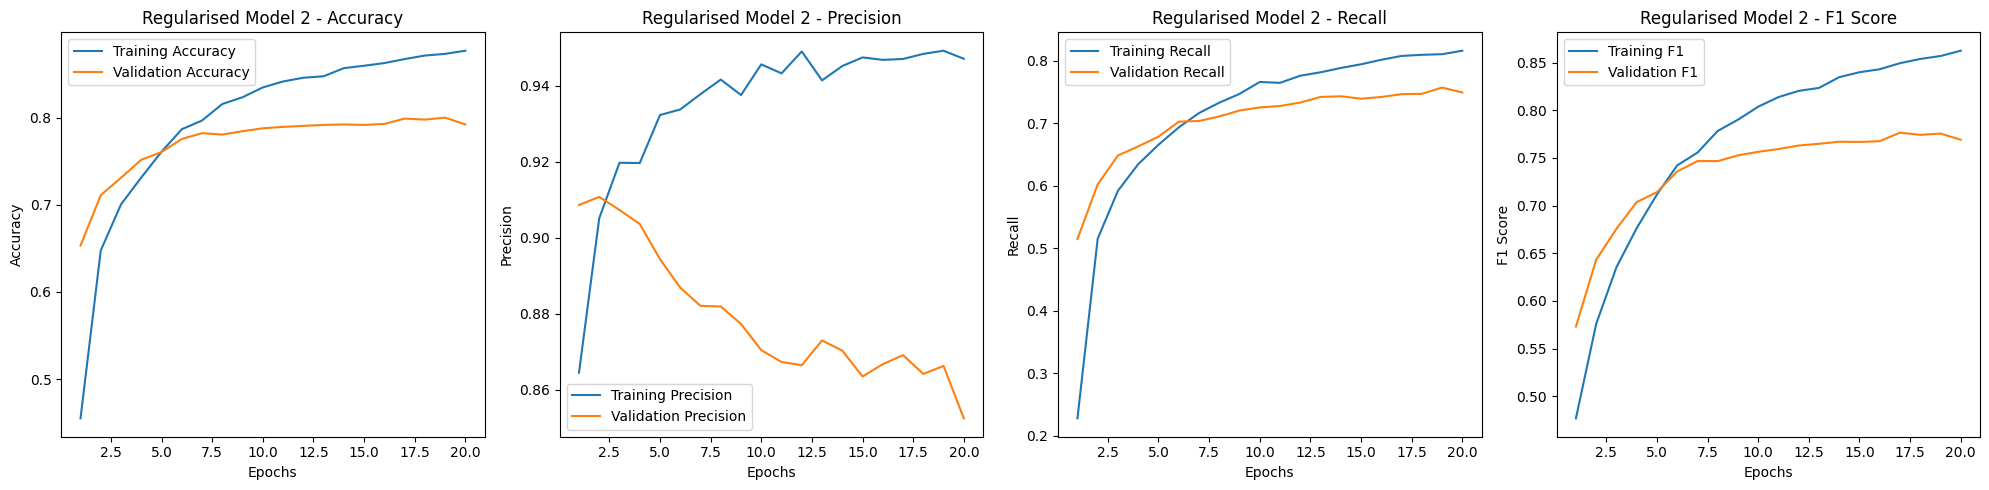


Overfitting Analysis for Regularised Model 2:
--------------------------------------------------
Optimal epoch (F1): 17
Optimal epoch (Accuracy): 19
Best validation F1: 0.7765
Best validation Accuracy: 0.8002
Final F1 gap (train-val): 0.0933
Final Accuracy gap (train-val): 0.0847


In [15]:
# Regularised model 2
print("\n4. Training Regularised Model 2")
regularised_model2 = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(10000,)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(46, activation='softmax')
])
regularised_model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)
regularised_history2 = regularised_model2.fit(
    x_train, one_hot_train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)
plot_metrics(regularised_history2, "Regularised Model 2")
analyse_overfitting(regularised_history2, "Regularised Model 2")

In [16]:
def optimise(hp):
    model = Sequential()

    # Regularisation hyperparameters
    l1_reg = hp.Float('l1_reg', min_value=1e-6, max_value=1e-3, sampling='log')
    l2_reg = hp.Float('l2_reg', min_value=1e-6, max_value=1e-3, sampling='log')
    use_dropout = hp.Boolean('use_dropout')
    dropout = hp.Float('dropout', 0.3, 0.5, step=0.1) if use_dropout else 0.0

    # Existing hyperparameters
    n_layers = hp.Int('n_layers', 1, 3)
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])
    first_layer = hp.Choice('first_layer', [128, 64, 46])

    # First layer with regularisation
    model.add(Dense(
        first_layer,
        activation=activation,
        input_shape=(10000,),
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
    ))
    if use_dropout:
        model.add(Dropout(dropout))

    # Additional layers with regularisation
    for i in range(n_layers - 1):
        layer_size = hp.Choice(f'layer_{i}', [64, 46])
        model.add(Dense(
            layer_size,
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
        ))
        if use_dropout:
            model.add(Dropout(dropout))

    model.add(Dense(46, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

In [17]:
print("\nStarting Hyperparameter Search with Keras Tuner:")

# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score',
    patience=5,
    min_delta=1e-4,
    mode='max',
    restore_best_weights=True
)

tuner = kt.Hyperband(
    optimise,
    objective=kt.Objective('val_f1_score', direction='max'),
    max_epochs=50,  # Increased since we have early stopping
    directory='reuters_tuning3',
    project_name='reuters11',
    factor=3
)

tuner.search(
    x_train, one_hot_train_labels,
    validation_split=0.2,
    epochs=50,  # Increased to match max_epochs
    callbacks=[early_stopping],
    verbose=1
)

Trial 90 Complete [00h 06m 40s]
val_f1_score: 0.7912772297859192

Best val_f1_score So Far: 0.814486026763916
Total elapsed time: 01h 01m 48s


In [18]:
best_hps = tuner.get_best_hyperparameters()[0]
print("\nBest Hyperparameters:", best_hps.values)


Best Hyperparameters: {'l1_reg': 2.352060599215416e-05, 'l2_reg': 3.6879810079731374e-06, 'use_dropout': True, 'n_layers': 1, 'learning_rate': 0.001, 'activation': 'tanh', 'first_layer': 46, 'dropout': 0.4, 'layer_0': 46, 'layer_1': 46, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0055'}


In [19]:
# Best model
best_model = tuner.hypermodel.build(best_hps)

# Compile the model
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=metrics
)

# Fit the model with early stopping
best_history = best_model.fit(
    x_train, one_hot_train_labels,
    epochs=50,  # Increased epochs since we have early stopping
    validation_split=0.2,
    callbacks=[early_stopping],  # Added early stopping
    verbose=1
)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5192 - f1_score: 0.6144 - loss: 2.3925 - precision: 0.8066 - recall: 0.2207 - val_accuracy: 0.7490 - val_f1_score: 0.7009 - val_loss: 1.2597 - val_precision: 0.9076 - val_recall: 0.6016
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7897 - f1_score: 0.7553 - loss: 1.1245 - precision: 0.9226 - recall: 0.6287 - val_accuracy: 0.7952 - val_f1_score: 0.7669 - val_loss: 1.0810 - val_precision: 0.8975 - val_recall: 0.6722
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8617 - f1_score: 0.8461 - loss: 0.8608 - precision: 0.9373 - recall: 0.7301 - val_accuracy: 0.8130 - val_f1_score: 0.7919 - val_loss: 1.0192 - val_precision: 0.8921 - val_recall: 0.7040
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8995 - f1_score: 0.8923 - loss: 0.7018 - precision: 0.9493 - recall: 0.8012 - val_accuracy: 0.8203 - val_f1_score: 0.8027 - val_loss: 0.9888 - val_precision: 0.8875 - val_rec

Available metrics: dict_keys(['accuracy', 'f1_score', 'loss', 'precision', 'recall', 'val_accuracy', 'val_f1_score', 'val_loss', 'val_precision', 'val_recall'])


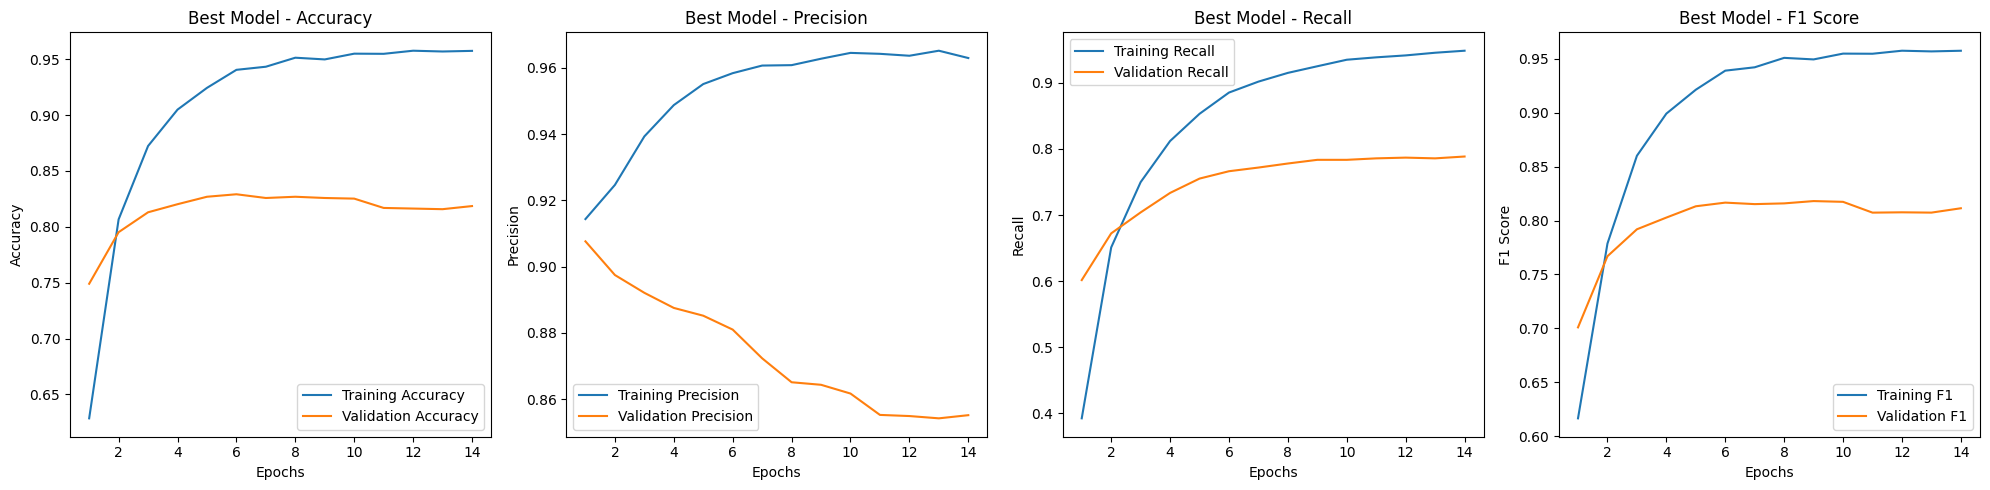


Overfitting Analysis for Best Model:
--------------------------------------------------
Optimal epoch (F1): 9
Optimal epoch (Accuracy): 6
Best validation F1: 0.8180
Best validation Accuracy: 0.8292
Final F1 gap (train-val): 0.1461
Final Accuracy gap (train-val): 0.1390


In [20]:
plot_metrics(best_history, "Best Model")
analyse_overfitting(best_history, "Best Model")

In [21]:
def print_model_comparison_table(results):
    headers = ['Model', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
    col_widths = []

    # Calculate column widths
    col_widths.append(max(len(h) for h in [headers[0]] + list(results.keys())))
    for i in range(1, len(headers)):
        col_widths.append(max(len(headers[i]),
                             max(len(f"{metric:.4f}") for model_metrics in results.values() for metric in model_metrics)))

    # Print header
    header = ' | '.join(h.ljust(w) for h, w in zip(headers, col_widths))
    print('\n' + header)
    print('-' * len(header))

    # Print rows
    for model_name, metrics in results.items():
        # Assuming metrics are in order: loss, accuracy, precision, recall, f1, val_loss, val_accuracy, val_precision, val_recall, val_f1
        values = [f"{v:.4f}" for v in metrics]
        row = [model_name] + values
        formatted_row = ' | '.join(str(v).ljust(w) for v, w in zip(row, col_widths))
        print(formatted_row)

In [22]:
models = {
   'Baseline': model,
   'Small': small_model,
   'Bigger': bigger_model,
   'Bigger2': bigger_model2,
   'Regularised': regularised_model,
   'Regularised2': regularised_model2,
   'Best HP': best_model,
}

In [23]:
results_comparison = {}

for name, model in models.items():
   test_metrics = model.evaluate(x_test, one_hot_test_labels, verbose=0)
   results_comparison[name] = test_metrics

print("\nModel Comparison:")
print_model_comparison_table(results_comparison)


Model Comparison:

Model        | Loss   | Accuracy | Precision | Recall | F1-Score
----------------------------------------------------------------
Baseline     | 1.9113 | 0.5521   | 0.9502    | 0.3059 | 0.4441  
Small        | 1.0510 | 0.7939   | 0.8270    | 0.7747 | 0.7837  
Bigger       | 1.1406 | 0.7943   | 0.8264    | 0.7734 | 0.7843  
Bigger2      | 1.1573 | 0.7965   | 0.8256    | 0.7796 | 0.7865  
Regularised  | 1.3110 | 0.7716   | 0.8240    | 0.7360 | 0.7585  
Regularised2 | 1.3650 | 0.7818   | 0.8485    | 0.7431 | 0.7617  
Best HP      | 1.0653 | 0.8077   | 0.8498    | 0.7609 | 0.7992  


In [24]:
analyse_overfitting(small_history, "Small Model")
analyse_overfitting(bigger_history, "Bigger Model")
analyse_overfitting(bigger_history2, "Bigger Model 2")
analyse_overfitting(regularised_history, "Regularised Model")
analyse_overfitting(regularised_history2, "Regularised Model 2")
analyse_overfitting(best_history, "Best Model")


Overfitting Analysis for Small Model:
--------------------------------------------------
Optimal epoch (F1): 5
Optimal epoch (Accuracy): 5
Best validation F1: 0.7985
Best validation Accuracy: 0.8136
Final F1 gap (train-val): 0.1639
Final Accuracy gap (train-val): 0.1537

Overfitting Analysis for Bigger Model:
--------------------------------------------------
Optimal epoch (F1): 5
Optimal epoch (Accuracy): 4
Best validation F1: 0.7989
Best validation Accuracy: 0.8086
Final F1 gap (train-val): 0.1693
Final Accuracy gap (train-val): 0.1600

Overfitting Analysis for Bigger Model 2:
--------------------------------------------------
Optimal epoch (F1): 4
Optimal epoch (Accuracy): 4
Best validation F1: 0.7996
Best validation Accuracy: 0.8097
Final F1 gap (train-val): 0.1686
Final Accuracy gap (train-val): 0.1605

Overfitting Analysis for Regularised Model:
--------------------------------------------------
Optimal epoch (F1): 10
Optimal epoch (Accuracy): 8
Best validation F1: 0.7951
Best v